In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import time
import preprocessing as pre
import tensorflow.contrib.layers as layers
import random
import matplotlib.pyplot as plt

In [15]:
train_data, train_label = pre.getDataFrame('F:/raw/train/')

In [16]:
test_data, test_label = pre.getDataFrame('F:/raw/validation/')

In [4]:
train_data.shape, train_label.shape

((55, 30, 112, 112, 3), (55, 5))

In [5]:
test_data.shape, test_label.shape

((35, 30, 112, 112, 3), (35, 5))

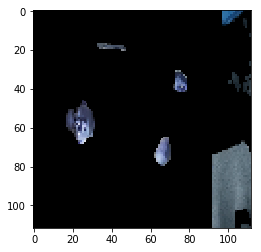

In [6]:
plt.imshow(train_data[1][0], cmap='gray')

In [17]:
class Model(object):
    def __init__(self,
            num_class = 5,
            keep_prob = 0.6,
            batch_size = 5,
            epoch=1,
            lr = 1e-4):
        self.IMG_WIDTH = 112
        self.IMG_HEIGHT = 112
        
        self.graph = tf.Graph()
        self.num_class = num_class
        self.epoch = epoch
        self.CLIP_LENGTH = 30
        self.keep_prob = keep_prob
        self.batch_size = batch_size
        
        self.n_step_epoch=int(30/batch_size)
        with self.graph.as_default():
            # [batch, in_depth, in_height, in_width, in_channels]
            self.inputs = tf.placeholder(tf.float32, [None, self.CLIP_LENGTH, self.IMG_HEIGHT, self.IMG_WIDTH, 3])
            self.labels = tf.placeholder(tf.int64, [None, self.num_class])

            self.initializer = layers.xavier_initializer()
            self.global_step = tf.Variable(0, trainable = False, name = "global_step")
            self.lr = lr
            tf.add_to_collection(tf.GraphKeys.GLOBAL_STEP, self.global_step)
         
    def conv3d(self, inputs, shape, name, w_name, b_name):
        with self.graph.as_default():
            with tf.variable_scope('var_name') as var_scope:
                W = tf.get_variable(name = w_name, shape = shape, initializer = self.initializer, dtype = tf.float32)
                b = tf.get_variable(name = b_name, shape = shape[-1], initializer = tf.zeros_initializer(), dtype = tf.float32)
                tf.add_to_collection(tf.GraphKeys.WEIGHTS, W)
                tf.add_to_collection(tf.GraphKeys.BIASES, b)
            return tf.nn.relu(tf.nn.bias_add(tf.nn.conv3d(inputs, W, strides = [1, 1, 1, 1, 1], padding = "SAME"), b))
        
    def fc(self, inputs, shape, name,w_name,b_name,activation = True):
        with self.graph.as_default():
            with tf.variable_scope('var_name') as var_scope:
                W = tf.get_variable(name = w_name, shape = shape, initializer = self.initializer, dtype = tf.float32)
                b = tf.get_variable(name = b_name, shape = shape[-1], initializer = tf.zeros_initializer(), dtype = tf.float32)
                tf.add_to_collection(tf.GraphKeys.WEIGHTS, W)
                tf.add_to_collection(tf.GraphKeys.BIASES, b)

            if activation:
                return tf.nn.relu(tf.nn.bias_add(tf.matmul(inputs, W), b))
            else:
                return tf.nn.bias_add(tf.matmul(inputs, W), b)
            
    def parseNet(self, net, netstruct, istraining = True):
        for key in netstruct:
            if key[0] == "conv":
                net = self.conv3d(net, key[2], key[1],key[3], key[4])
            elif key[0] == "fc":
                net = self.fc(net, key[2], key[1], key[3], key[4],activation = key[-1])
            elif key[0] == "maxpool":
                net = tf.nn.max_pool3d(net, ksize = key[2], strides = key[2], padding = "SAME", name = key[1])
            elif key[0] == "dropout" and istraining:
                net = tf.nn.dropout(net, key[2], name = key[1])
            elif key[0] == "reshape":
                net = tf.reshape(net, key[-1])
            elif key[0] == "softmax":
                net = tf.nn.softmax(net)
            elif key[0] == "transpose":
                net = tf.transpose(net, perm=key[-1])
        return net

    def train(self, data, label):
        with self.graph.as_default():
            
#             [filter_depth, filter_height, filter_width, in_channels, out_channels]
            c3d_net = [
                ["conv", "conv1", [3, 3, 3, 3, 64], 'wc1', 'bc1'],
                ["maxpool", "pool1", [1, 1, 2, 2, 1]],
                ["conv", "conv2", [3, 3, 3, 64, 128], 'wc2', 'bc2'],
                ["maxpool", "pool2", [1, 2, 2, 2, 1]],
                ["conv", "conv3a", [3, 3, 3, 128, 256], 'wc3a', 'bc3a'],
                ["conv", "conv3b", [3, 3, 3, 256, 256], 'wc3b', 'bc3b'],
                ["maxpool", "pool3", [1, 2, 2, 2, 1]],
                ["conv", "conv4a", [3, 3, 3, 256, 512], 'wc4a', 'bc4a'],
                ["conv", "conv4b", [3, 3, 3, 512, 512], 'wc4b', 'bc4b'],
                ["maxpool", "pool4", [1, 2, 2, 2, 1]],
                ["conv", "conv5a", [3, 3, 3, 512, 512], 'wc5a', 'bc5a'],
                ["conv", "conv5b", [3, 3, 3, 512, 256], 'wc5b', 'bc5b'],
                ["maxpool", "pool5", [1, 2, 2, 2, 1]],
                ["transpose", [0, 1, 4, 2, 3]],  #only use it if you restore the sports1m_finetuning_ucf101.model, otherwise uncomment it,(e.g use conv3d_deepnetA_sport1m_iter_1900000_TF.model)
                ["reshape", [-1, 8192]],
                ["fc", "fc1", [8192, 4096], 'wd1', 'bd1', True],
                ["dropout", "dropout1", self.keep_prob],
                ["fc", "fc2", [4096, 4096],'wd2','bd2', True],
                ["dropout", "dropout2", self.keep_prob],
                ["fc", "fc3", [4096, self.num_class],'wout','bout',False],
            ]

            # print(tf.trainable_variables())
            # print(var_list)
            # print(tf.get_collection(tf.GraphKeys.WEIGHTS))

            # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.5)

            with tf.Session() as sess:
                logits = self.parseNet(self.inputs, c3d_net)
                softmax_logits = tf.nn.softmax(logits)
                # int_label = tf.one_hot(self.labels, self.num_class)
                int_label = self.labels  # [bs,101]-->[bs*4 or 8 or 16,101]
                # int_label=tf.concat(
                #     [int_label,int_label,int_label,int_label,],axis=0)

                int_label=tf.cast(int_label,dtype=tf.int64)
#                 task_loss = tf.reduce_sum(
#                     tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=int_label))
                task_loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = int_label))
                # task_loss = -tf.reduce_sum(int_label*tf.log(logits))
#                 acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(softmax_logits, axis=1), int_label), tf.float32))
#                 right_count = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(softmax_logits, axis=1), int_label), tf.int32))
    
                reg_loss = layers.apply_regularization(layers.l2_regularizer(5e-4),
                                                       tf.get_collection(tf.GraphKeys.WEIGHTS))
                total_loss = task_loss + reg_loss
                train_var_list = [v for v in tf.trainable_variables() if v.name.find("conv") == -1]
                train_op = tf.train.GradientDescentOptimizer(self.lr).minimize(
                    total_loss, global_step=self.global_step)
#                 train_op = tf.train.MomentumOptimizer(self.lr,0.9).minimize(
#                     total_loss, global_step = self.global_step,var_list=train_var_list)
#                 train_op = tf.train.AdamOptimizer(self.lr).minimize(total_loss)
    
    
                total_para = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
                print('total_para:', total_para)

                init = tf.global_variables_initializer()
                # var_list = [v for v in tf.trainable_variables() if v.name.find("conv") != -1]
                # print(var_list)
                # saver = tf.train.Saver(tf.global_variables())
                sess.run(init)
                saver = tf.train.Saver(tf.trainable_variables())
                ############################################################
                saver.restore(sess, tf.train.latest_checkpoint('../model/'))
                ############################################################

                # print("Model Loading Done!")
                step = 0
                total_batch = int(len(data) / self.batch_size)
                for epoch in range(self.epoch):
                    next_start_pos = 0
                    total_cost = 0
                    for i in tqdm(range(total_batch)):
                        train_batch = data[next_start_pos:next_start_pos+self.batch_size] 
                        label_batch = label[next_start_pos:next_start_pos+self.batch_size] 
                        next_start_pos += self.batch_size 
                        assert len(train_batch)==self.batch_size
                        val_feed = {self.inputs: train_batch, self.labels: label_batch}
#                         print(sess.run(tf.size(logits), val_feed))
                        _, cost = sess.run([train_op, task_loss], val_feed)
                        total_cost += cost
                    print('Avg. cost:', total_cost / total_batch)
                saver.save(sess, '../model/c3d.ckpt')
                
    def test(self, data, label):
        with self.graph.as_default():
            
#             [filter_depth, filter_height, filter_width, in_channels, out_channels]
            c3d_net = [
                ["conv", "conv1", [3, 3, 3, 3, 64], 'wc1', 'bc1'],
                ["maxpool", "pool1", [1, 1, 2, 2, 1]],
                ["conv", "conv2", [3, 3, 3, 64, 128], 'wc2', 'bc2'],
                ["maxpool", "pool2", [1, 2, 2, 2, 1]],
                ["conv", "conv3a", [3, 3, 3, 128, 256], 'wc3a', 'bc3a'],
                ["conv", "conv3b", [3, 3, 3, 256, 256], 'wc3b', 'bc3b'],
                ["maxpool", "pool3", [1, 2, 2, 2, 1]],
                ["conv", "conv4a", [3, 3, 3, 256, 512], 'wc4a', 'bc4a'],
                ["conv", "conv4b", [3, 3, 3, 512, 512], 'wc4b', 'bc4b'],
                ["maxpool", "pool4", [1, 2, 2, 2, 1]],
                ["conv", "conv5a", [3, 3, 3, 512, 512], 'wc5a', 'bc5a'],
                ["conv", "conv5b", [3, 3, 3, 512, 256], 'wc5b', 'bc5b'],
                ["maxpool", "pool5", [1, 2, 2, 2, 1]],
                ["transpose", [0, 1, 4, 2, 3]],  #only use it if you restore the sports1m_finetuning_ucf101.model, otherwise uncomment it,(e.g use conv3d_deepnetA_sport1m_iter_1900000_TF.model)
                ["reshape", [-1, 8192]],
                ["fc", "fc1", [8192, 4096], 'wd1', 'bd1', True],
                ["dropout", "dropout1", self.keep_prob],
                ["fc", "fc2", [4096, 4096],'wd2','bd2', True],
                ["dropout", "dropout2", self.keep_prob],
                ["fc", "fc3", [4096, self.num_class],'wout','bout',False],
            ]

            with tf.Session() as sess:
                logits = self.parseNet(self.inputs, c3d_net)
                softmax_logits = tf.nn.softmax(logits)

                int_label = self.labels

                int_label=tf.cast(int_label,dtype=tf.int64)

#                 right_count = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(softmax_logits, axis=1), int_label), tf.int32))    
                acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, axis=1), tf.argmax(int_label, axis=1)), tf.float32))
                total_para = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
                print('total_para:', total_para)

                init = tf.global_variables_initializer()
                
                sess.run(init)
                saver = tf.train.Saver(tf.trainable_variables())
                saver.restore(sess, tf.train.latest_checkpoint('../model/'))
                print("Model Loading Done!")
                
#                 total_batch = int(len(data) / self.batch_size)
                
#                 next_start_pos = 0
#                 cnt = 0
                
#                 for i in tqdm(range(total_batch)):
#                     test_batch = data[next_start_pos:next_start_pos+self.batch_size] 
#                     label_batch = label[next_start_pos:next_start_pos+self.batch_size] 
#                     next_start_pos += self.batch_size 
#                     assert len(test_batch)==self.batch_size
#                     val_feed = {self.inputs: test_batch, self.labels: label_batch}
# #                         print(sess.run(tf.size(logits), val_feed))
#                     cnt += sess.run(right_count, val_feed)
                test_data = data
                test_label = label
            
                val_feed = {self.inputs: test_data, self.labels:test_label}
                
                    
                print('Accuracy:', sess.run(acc, val_feed))
                
    def run(self, data, label):
        with self.graph.as_default():
            c3d_net = [
                ["conv", "conv1", [3, 3, 3, 3, 64], 'wc1', 'bc1'],
                ["maxpool", "pool1", [1, 1, 2, 2, 1]],
                ["conv", "conv2", [3, 3, 3, 64, 128], 'wc2', 'bc2'],
                ["maxpool", "pool2", [1, 2, 2, 2, 1]],
                ["conv", "conv3a", [3, 3, 3, 128, 256], 'wc3a', 'bc3a'],
                ["conv", "conv3b", [3, 3, 3, 256, 256], 'wc3b', 'bc3b'],
                ["maxpool", "pool3", [1, 2, 2, 2, 1]],
                ["conv", "conv4a", [3, 3, 3, 256, 512], 'wc4a', 'bc4a'],
                ["conv", "conv4b", [3, 3, 3, 512, 512], 'wc4b', 'bc4b'],
                ["maxpool", "pool4", [1, 2, 2, 2, 1]],
                ["conv", "conv5a", [3, 3, 3, 512, 512], 'wc5a', 'bc5a'],
                ["conv", "conv5b", [3, 3, 3, 512, 256], 'wc5b', 'bc5b'],
                ["maxpool", "pool5", [1, 2, 2, 2, 1]],
                ["transpose", [0, 1, 4, 2, 3]],
                ["reshape", [-1, 8192]],
                ["fc", "fc1", [8192, 4096], 'wd1', 'bd1', True],
                ["dropout", "dropout1", self.keep_prob],
                ["fc", "fc2", [4096, 4096],'wd2','bd2', True],
                ["dropout", "dropout2", self.keep_prob],
                ["fc", "fc3", [4096, self.num_class],'wout','bout',False],
            ]

            with tf.Session() as sess:
                logits = self.parseNet(self.inputs, c3d_net)

                int_label = self.labels

                int_label=tf.cast(int_label,dtype=tf.int64)

                result = tf.equal(tf.argmax(logits, axis=1), tf.argmax(int_label, axis=1))

                init = tf.global_variables_initializer()

                sess.run(init)
                saver = tf.train.Saver(tf.trainable_variables())
                saver.restore(sess, tf.train.latest_checkpoint('../model/'))
                print("Model Loading Done!")

                run_data = data
                run_label = label

                val_feed = {self.inputs: run_data, self.labels:run_label}


                return sess.run(result, val_feed)

In [18]:
if __name__ == "__main__":
    c3dnet = Model()
    c3dnet.train(train_data, train_label)

total_para: 74477061


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [09:35<00:00, 52.65s/it]


Avg. cost: 14.538407010110943


In [19]:
if __name__ == "__main__":
    c3dnet = Model()
    c3dnet.test(test_data, test_label)

total_para: 74477061
INFO:tensorflow:Restoring parameters from ../model/c3d.ckpt
Model Loading Done!
Accuracy: 0.17142858
